In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops,loopInterpolate,tailUpMs2
from autocorrelationDataProcessing import tracePackageAutocorrelation
from autocorrelationAnalyticInference import fitAutocorrelationFunction

In [3]:
# define all needed parameters for simulation and fitting #
stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0016
k_off = 0.011
duration = 445   # seconds
num = 100           # number of traces in our simulated dataset

loop_function = tailUpMs2().loop_function

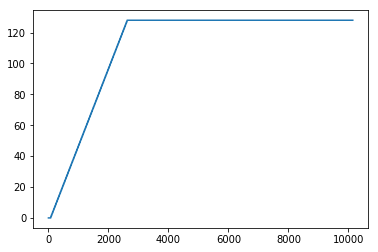

In [18]:
plt.plot(loop_function)

In [4]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [5]:
tracelist = tracePackage.tracelist

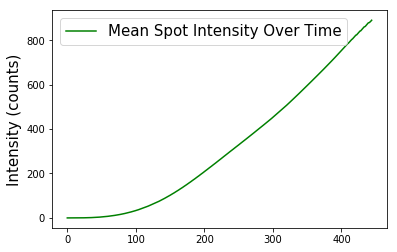

In [6]:
plt.plot(np.mean(tracelist, axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [7]:
# define start and stop indeces
start_index = 350
stop_index = -1

In [8]:
autopackage = tracePackageAutocorrelation(tracelist, loop_function, start_index, stop_index)

In [9]:
t = np.arange(len(autopackage.tracelist[1][1:])) * stepsize

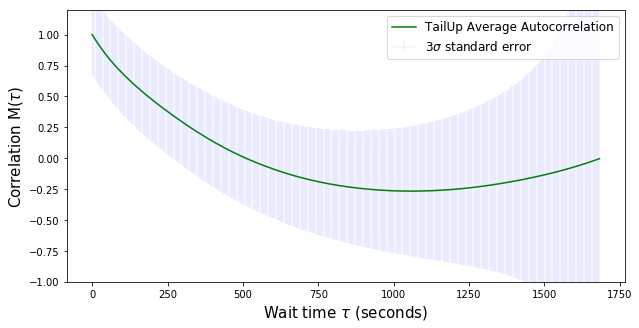

In [10]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
autoav = autopackage.autoav
autostd = autopackage.autostd
avgflors = autopackage.avgflors

ax.plot(t, autoav, color = 'g', label = "TailUp Average Autocorrelation")
ax.errorbar(x=t, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'3$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

In [11]:
# fit for pon in a SIMPLE way
def fitPon(autopackage, loop_function):
    avg_flors = autopackage.avgflors
    pon = np.mean(avg_flors / np.sum(loop_function)) 
    pon_std = np.std(avg_flors/ np.sum(loop_function)) 

    return pon,pon_std

In [12]:
pon,pstd = fitPon(autopackage, loop_function)
print(pon)

0.3517398283201898


In [13]:
fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)

In [14]:
kon_fit,koff_fit,chrtime,pon,popt,pcov,weightstd = fitAutoPack.leastSquaresAutoFit(printvals=True, 
                                                                                   upperbound=0.1, lowerbound=0.001)

([0.001], [0.1])
Pon                       =  0.35173982832018974
k_on + k_off              =  0.025683305620481798 s^-1
k_on                      =  0.009033841509643231
k_off                     =  0.016649464110838567
t_polII_block             =  6 seconds
characteristic timescale  =  38.93579801513263 time units
covariance                =  2.418656374041076e-06


In [15]:
# something to plot with
t = np.arange(len(autoav))

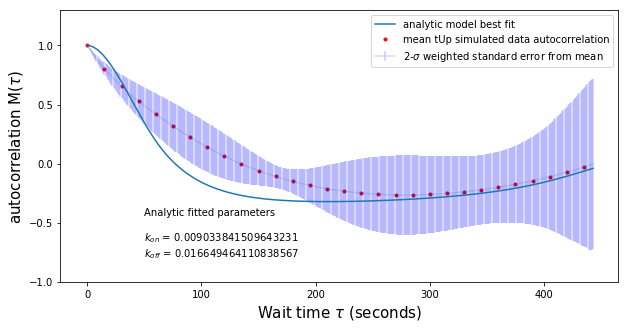

In [16]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)

ax.plot(t, fitAutoPack.autocorrAnalytic(t,1/chrtime), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t[::15],autoav[::15], marker='.', 
                   color='r', label = 'mean tUp simulated data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t, y=autoav, yerr=(weightstd*2, weightstd*2), 
                        ecolor='b', alpha=0.2, label = r'2-$\sigma$ weighted standard error from mean')  

#plt.plot(chrtime, 1/(np.e), size=20, color='r')
plt.legend(loc="best")
ax.set_ylim(-1, 1.3)
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'autocorrelation M($\tau$)', fontsize=15)
#plt.text(x=0.07, y=-1.8, 
             #s='Simulated Parameters \n\n$k_{on}$ =' + str(k_on) +
                    # '\n$k_{off}$ = ' + str(k_off) +  '\n$k_{elong}$ = '+ str(k_elong) 
                             #+ ' bp/sec \nobservation time = '+ str(stepsize) + ' seconds')
plt.text(x=50, y=-.8, s='Analytic fitted parameters \n\n$k_{on}$ = ' 
                                 + str(kon_fit) + '\n$k_{off}$ = ' + str(koff_fit))
plt.show()

In [17]:
np.linalg.eig(pcov)

(array([2.41865637e-06]), array([[1.]]))

In [18]:
# some tricks to get info we need to plot an ellipse, aligned with # some t 
#    the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(pcov)
angle = np.degrees(np.arctan2(eigvec[0,0], eigvec[0,0]))
w = 2*np.sqrt(eigval)
h=0

In [19]:
w

array([0.00179974])

In [20]:
pars = [kon_fit,koff_fit]

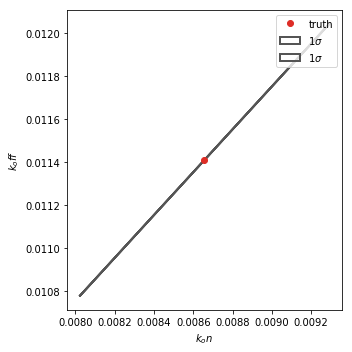

In [21]:
from  matplotlib.patches  import Ellipse

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,1]:
    ax.add_patch(Ellipse(pars, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax.plot(kon_fit, koff_fit, marker='o', zorder=10, linestyle='none',
        color='#de2d26', label='truth')

ax.set_xlabel('$k_on$')
ax.set_ylabel('$k_off$')
ax.legend(loc='best')

fig.tight_layout()